In [34]:
import numpy as np
import pandas as pd
import yfinance
from pymongo import MongoClient
import pickle as pk

In [35]:
# Function to pull data from MongoDB and convert it to DataFrames
def pulling_data_db():
    # Connect to MongoDB
    client = MongoClient('localhost', 27017)
    db = client['financeStockData']

    collection = db['AAPL_stock_data']
    
    # Fetch all documents from each collection
    dt1 = list(collection.find())     # Convert cursor to list for DataFrame
 
    # Convert list of documents (dictionaries) to pandas DataFrames
    appl_data = pd.DataFrame(dt1)
    
    return appl_data # tesl_fin, goo_fin

In [36]:
fin_data = pulling_data_db()
fin_data.head()

,_id,Date,Open,High,Low,Close,Adj Close,Volume
0,6717b67af296b51242ed03dd,2023-10-23,170.910004,174.009995,169.929993,173.000000,172.119263,55980100
1,6717b67af296b51242ed03de,2023-10-24,173.050003,173.669998,171.449997,173.440002,172.557007,43816600
2,6717b67af296b51242ed03df,2023-10-25,171.880005,173.059998,170.649994,171.100006,170.228943,57157000
3,6717b67af296b51242ed03e0,2023-10-26,170.369995,171.380005,165.669998,166.889999,166.040375,70625300
4,6717b67af296b51242ed03e1,2023-10-27,166.910004,168.960007,166.830002,168.220001,167.363586,58499100


In [37]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _id        271 non-null    object 
 1   Date       271 non-null    object 
 2   Open       271 non-null    float64
 3   High       271 non-null    float64
 4   Low        271 non-null    float64
 5   Close      271 non-null    float64
 6   Adj Close  271 non-null    float64
 7   Volume     271 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 17.1+ KB


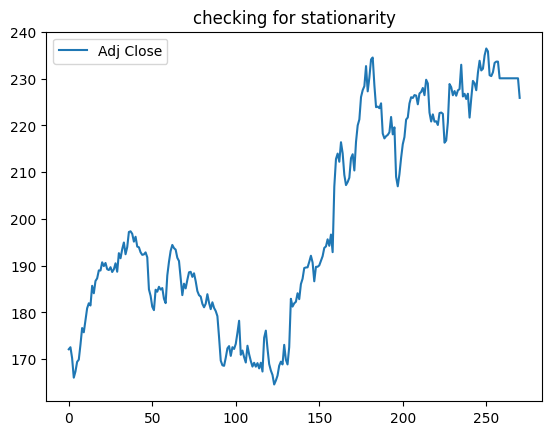

In [38]:
fin_data = fin_data[["Date", "Adj Close"]]
fin_data.plot(kind='line', title = "checking for stationarity");

In [39]:
fin_data.index = pd.to_datetime(fin_data.index)

In [40]:
# Average stock prices per month, week and day
weekly_price = fin_data['Adj Close'].resample('W').mean()
monthly_price = fin_data['Adj Close'].resample('M').mean()
daily_price = fin_data['Adj Close'].resample('D').mean()

print(f"Weekly average price of stock is {weekly_price}")
print(f"Monthly average price of stock is {monthly_price}")
print(f"Daily average price of stock is {daily_price}")

Weekly average price of stock is 1970-01-04    199.530643
Freq: W-SUN, Name: Adj Close, dtype: float64
Monthly average price of stock is 1970-01-31    199.530643
Freq: M, Name: Adj Close, dtype: float64
Daily average price of stock is 1970-01-01    199.530643
Freq: D, Name: Adj Close, dtype: float64


In [41]:
fin_data['Date'] = pd.to_datetime(fin_data['Date'])
fin_data['month'] = fin_data['Date'].dt.month
fin_data['day'] = fin_data['Date'].dt.day
fin_data['year'] = fin_data['Date'].dt.year
fin_data.head()

,Date,Adj Close,month,day,year
1970-01-01 00:00:00.000000000,2023-10-23,172.119263,10,23,2023
1970-01-01 00:00:00.000000001,2023-10-24,172.557007,10,24,2023
1970-01-01 00:00:00.000000002,2023-10-25,170.228943,10,25,2023
1970-01-01 00:00:00.000000003,2023-10-26,166.040375,10,26,2023
1970-01-01 00:00:00.000000004,2023-10-27,167.363586,10,27,2023


In [42]:
fin_data = fin_data.drop(columns = ['Date'], axis =1)
fin_data.head()

,Adj Close,month,day,year
1970-01-01 00:00:00.000000000,172.119263,10,23,2023
1970-01-01 00:00:00.000000001,172.557007,10,24,2023
1970-01-01 00:00:00.000000002,170.228943,10,25,2023
1970-01-01 00:00:00.000000003,166.040375,10,26,2023
1970-01-01 00:00:00.000000004,167.363586,10,27,2023


In [43]:
fin_data.duplicated().sum()

12

In [44]:
fin_data['Adj Close'].describe()

count    271.000000
mean     199.530643
std       22.284261
min      164.585999
25%      181.974152
50%      192.449707
75%      222.770004
max      236.479996
Name: Adj Close, dtype: float64

In [45]:
df = fin_data.values.flatten()

In [46]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):

    print('Results of Dickey-Fuller Test:')
    adf_test_result = adfuller(timeseries, autolag='AIC')
    
    adf_output = pd.Series(adf_test_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test_result[4].items():
        adf_output['Critical Value (%s)' % key] = value
    
    print(adf_output)

    # Interpret the p-value
    if adf_output['p-value'] < 0.05:
        print("\nConclusion: Reject the null hypothesis. The time series is stationary.")
    else:
        print("\nConclusion: Cannot reject the null hypothesis. The time series is non-stationary.")


In [47]:
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   -1.799483
p-value                           0.380718
#Lags Used                        3.000000
Number of Observations Used    1080.000000
Critical Value (1%)              -3.436419
Critical Value (5%)              -2.864220
Critical Value (10%)             -2.568197
dtype: float64

Conclusion: Cannot reject the null hypothesis. The time series is non-stationary.


In [48]:
season_length = 3
df_diff = fin_data['Adj Close'].diff(periods=season_length).dropna()  # Adjust season_length accordingly
df_diff

1970-01-01 00:00:00.000000003   -6.078888
1970-01-01 00:00:00.000000004   -5.193420
1970-01-01 00:00:00.000000005   -0.805908
1970-01-01 00:00:00.000000006    3.860229
1970-01-01 00:00:00.000000007    5.720718
                                   ...   
1970-01-01 00:00:00.000000266    0.000000
1970-01-01 00:00:00.000000267    0.000000
1970-01-01 00:00:00.000000268    0.000000
1970-01-01 00:00:00.000000269    0.000000
1970-01-01 00:00:00.000000270   -4.190002
Name: Adj Close, Length: 268, dtype: float64

<Axes: >

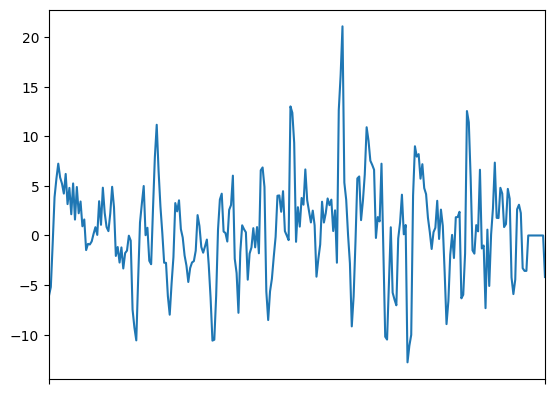

In [49]:
# df = pd.DataFrame(df_diff)
df_diff.plot(kind="line")

In [50]:
adf_test(df_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -4.546058
p-value                          0.000162
#Lags Used                      13.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64

Conclusion: Reject the null hypothesis. The time series is stationary.


In [51]:
df_smoothed = df_diff.rolling(window=2).mean()  # Adjust window size
df_smoothed.dropna(inplace=True)

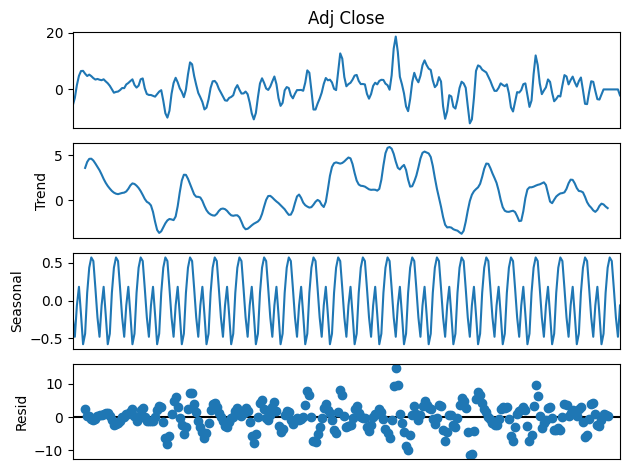

In [52]:
# Checking for trend in the time series data
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_smoothed, model='additive', period=12)  # Adjust 'period'

# Plot the decomposed components
decomposition.plot()
plt.show()

In [53]:
decomposition.trend

1970-01-01 00:00:00.000000004   NaN
1970-01-01 00:00:00.000000005   NaN
1970-01-01 00:00:00.000000006   NaN
1970-01-01 00:00:00.000000007   NaN
1970-01-01 00:00:00.000000008   NaN
                                 ..
1970-01-01 00:00:00.000000266   NaN
1970-01-01 00:00:00.000000267   NaN
1970-01-01 00:00:00.000000268   NaN
1970-01-01 00:00:00.000000269   NaN
1970-01-01 00:00:00.000000270   NaN
Name: trend, Length: 267, dtype: float64

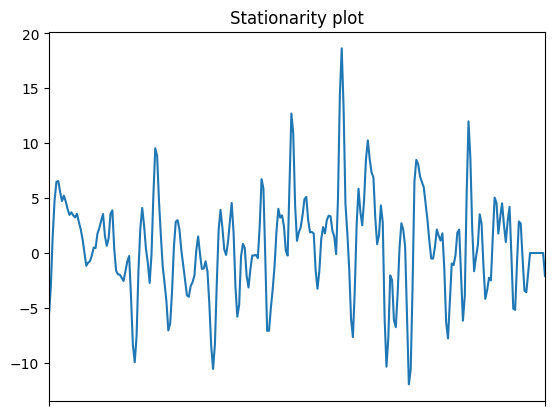

In [54]:
df_smoothed.plot(kind='line', title="Stationarity plot");

In [55]:
# Normalizing data
from sklearn.preprocessing import StandardScaler

def scaling_data(data):
    scale = StandardScaler()
    
    normalized_data = scale.fit_transform(data)
    
    return normalized_data

In [56]:
reshap = np.array(df_smoothed).reshape(-1, 1)
scalled = scaling_data(reshap)

df = pd.DataFrame(scalled)

In [57]:
df.head()

,0
0,-1.415977
1,-0.823084
2,0.194906
3,0.928759
4,1.309113


In [58]:
X_train = df.loc[0:199, ]
X_test = df.loc[199:, ]

In [59]:
print(X_train.shape)
print(X_test.shape)

(200, 1)
(68, 1)


In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

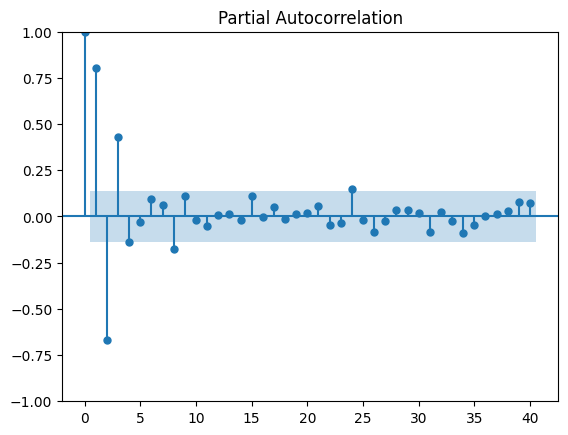

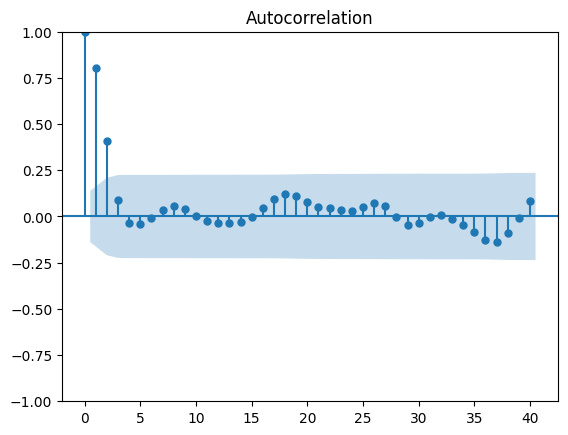

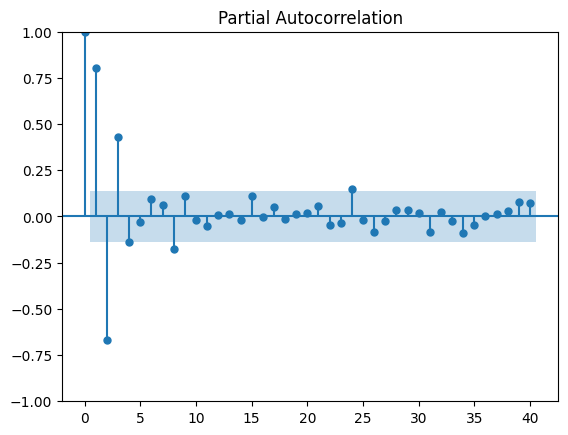

In [61]:
# selecting the parameters needed for building ARMA mode;
plot_acf(X_train, lags=40)
plot_pacf(X_train, lags=40)

In [73]:
p, d, q = 1, 2, 1
model = ARIMA(X_train, order=(p, d, q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      0   No. Observations:                  200
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -161.167
Date:                Sat, 02 Nov 2024   AIC                            328.333
Time:                        14:57:24   BIC                            338.198
Sample:                             0   HQIC                           332.326
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1476      0.088     -1.679      0.093      -0.320       0.025
ma.L1          0.7112      0.060     11.832      0.000       0.593       0.829
sigma2         0.2975      0.024     12.378      0.000       0.250       0.345
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                10.80
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               3.55   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

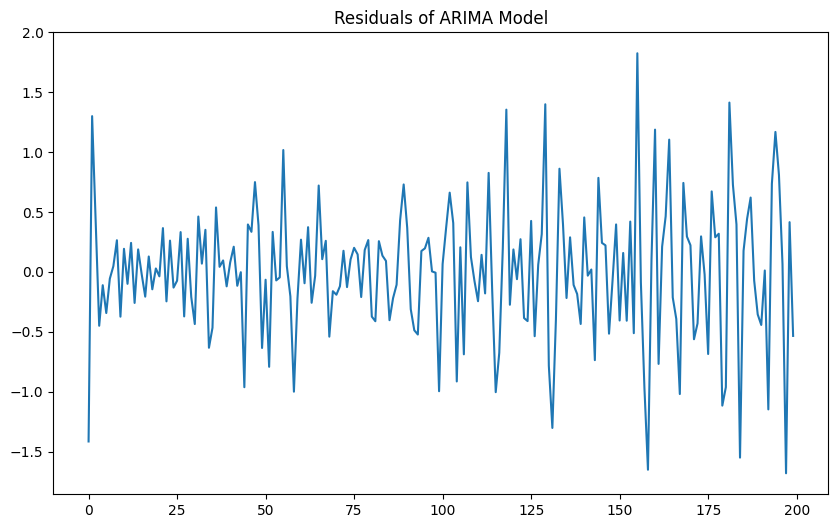

In [74]:
import matplotlib.pyplot as plt

residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

TypeError: 'int' object is not subscriptable

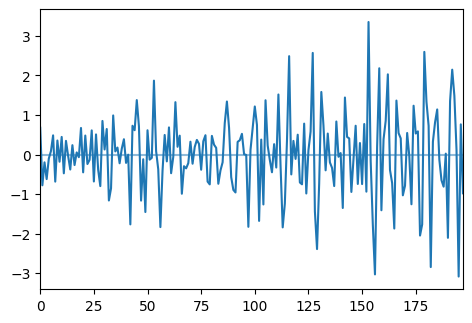

In [76]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [77]:
# Forecast the next steps
forecast_steps = 10  # Number of future steps to predict
forecast = model_fit.forecast(steps=forecast_steps)

print(f"Forecasted values: {forecast}")


Forecasted values: 200    0.812261
201    0.258593
202   -0.302833
203   -0.863115
204   -1.423565
205   -1.983990
206   -2.544419
207   -3.104848
208   -3.665277
209   -4.225705
Name: predicted_mean, dtype: float64


In [79]:
import pickle as pk

with open('arima_model.pkl', 'wb') as file:
    pk.dump(model_fit, file)

print("Model saved successfully!")

Model saved successfully!
